# visualize_route.ipynb
Visualize VRP routes from a nodes CSV and a solution_routes.json.

In [1]:
# === Parameters ===
# Set these to your actual files before running.
nodes_filepath = "vrp_nodes.csv"                 # path to CSV with columns: id,lat,lon[,demand]
solution_routes_filepath = "results/ga_cx_inversion/solution_routes.json"  # path to JSON produced by routes_to_json(...)

# === Imports ===
import json, math
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Utility: great-circle distance (meters)
EARTH_R = 6_371_008.8  # meters
def haversine_m(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    p1, p2 = math.radians(lat1), math.radians(lat2)
    dphi = p2 - p1
    dlmb = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(p1)*math.cos(p2)*math.sin(dlmb/2)**2
    return 2 * EARTH_R * math.atan2(math.sqrt(a), math.sqrt(1-a))


In [2]:
# === Load Data ===
nodes_path = Path(nodes_filepath)
routes_path = Path(solution_routes_filepath)

if not nodes_path.exists():
    raise FileNotFoundError(f"nodes file not found: {nodes_path}")
if not routes_path.exists():
    raise FileNotFoundError(f"routes file not found: {routes_path}")

df_nodes = pd.read_csv(nodes_path).sort_values("id").reset_index(drop=True)
required_node_cols = {"id","lat","lon"}
missing = required_node_cols - set(df_nodes.columns)
if missing:
    raise ValueError(f"nodes CSV missing required columns: {missing}")

# id -> (lat, lon)
nodes_latlon = {int(r.id):(float(r.lat), float(r.lon)) for r in df_nodes.itertuples(index=False)}

with open(routes_path, "r", encoding="utf-8") as f:
    routes_json = json.load(f)

routes = routes_json.get("routes", [])
if not routes:
    raise ValueError("No routes found in solution_routes.json (expected key 'routes').")

print(f"Loaded {len(df_nodes)} nodes and {len(routes)} routes.")


FileNotFoundError: nodes file not found: vrp_nodes.csv

In [ ]:
# === Prepare edges per route (and compute distances) ===
# We also compute 'edges' that can optionally be written back into the JSON if desired.
augmented_routes = []
for route in routes:
    stops = route.get("stops_by_id", [])
    veh_name = route.get("vehicle_name", f"Vehicle-{route.get('vehicle_id','?')}")
    edges = []
    for u, v in zip(stops[:-1], stops[1:]):
        lat1, lon1 = nodes_latlon[int(u)]
        lat2, lon2 = nodes_latlon[int(v)]
        dist_m = haversine_m(lat1, lon1, lat2, lon2)
        edges.append({"u": int(u), "v": int(v), "distance_m": float(dist_m)})
    # Keep original fields, add edges
    new_r = dict(route)
    new_r["edges"] = edges
    augmented_routes.append(new_r)

routes_augmented = {"routes": augmented_routes}
print("Prepared per-edge distances for labeling.")


Prepared per-edge distances for labeling.


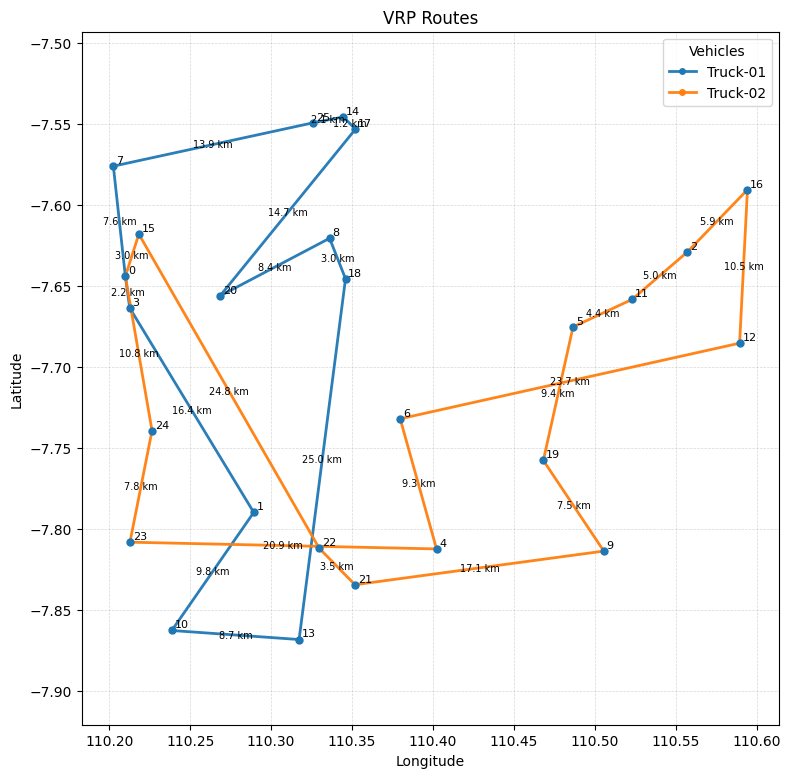

In [ ]:
# === Visualization ===
fig, ax = plt.subplots(figsize=(9, 9))

# Plot all nodes (lon on x-axis, lat on y-axis).
xs = [nodes_latlon[i][1] for i in sorted(nodes_latlon)]
ys = [nodes_latlon[i][0] for i in sorted(nodes_latlon)]
ax.scatter(xs, ys, s=25, zorder=3)

# Annotate each node with its id for clarity
for node_id in sorted(nodes_latlon):
    lat, lon = nodes_latlon[node_id]
    ax.annotate(str(node_id), (lon, lat), xytext=(2, 2), textcoords="offset points", fontsize=8)

# Draw each route with a unique color from matplotlib's cycle.
handles = []
labels = []
for r in routes_augmented["routes"]:
    stops = r["stops_by_id"]
    veh = r.get("vehicle_name", f"Vehicle-{r.get('vehicle_id','?')}")
    lons = [nodes_latlon[s][1] for s in stops]
    lats = [nodes_latlon[s][0] for s in stops]

    line, = ax.plot(lons, lats, marker="o", linewidth=2, markersize=4, alpha=0.95)  # color from cycle
    handles.append(line)
    labels.append(veh)

    # label distances for each edge at the midpoint
    for (i, e) in enumerate(r["edges"]):
        lon1, lat1 = lons[i], lats[i]
        lon2, lat2 = lons[i+1], lats[i+1]
        mid_lon = (lon1 + lon2) / 2.0
        mid_lat = (lat1 + lat2) / 2.0
        dist_km = e["distance_m"] / 1000.0
        ax.text(mid_lon, mid_lat, f"{dist_km:.1f} km", fontsize=7, ha="center", va="center", zorder=4)

ax.legend(handles, labels, title="Vehicles", loc="best")
ax.set_title("VRP Routes")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
ax.set_aspect("equal", adjustable="datalim")
plt.show()


In [ ]:
# === Optional: Write augmented routes JSON with per-edge distances ===
# Set this to True if you'd like to save the enriched JSON next to the original.
write_augmented = False

if write_augmented:
    out_path = Path(solution_routes_filepath).with_name("solution_routes_with_edges.json")
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(routes_augmented, f, indent=2)
    print("Augmented routes file written to:", out_path)
